In [1]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn pandas
!pip install statsmodels==0.14.0


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
import pandas as pd
from typing import List
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Práctica 6: Modelos Autoregresivos y de Medias Móviles

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Diseñe una clase para un modelo $AR(p)$. La clase debe permitir:

1. Recibir el orden $p$ para el que será entrenado en su construcción.
2. Tener un método que permita ajustar los parámetros del modelo usando el algoritmo de Durbin-Levinson.
3. Tener un método que permita imprimir el polinomio asociado al modelo. El polinomio tiene la forma

    $$
    \phi(z) = 1 - \phi_1 z - \phi_2 z^2 - \cdots - \phi_p z^p
    $$
    
4. Tener un método que imprima las raices del polinomio asociado. Puede apoyarse de la función _numpy.roots(p)_.
5. Un método booleano que indique si el polinomio es causal.
6. Un método que grafique la función de autocorrelación parcial (PACF).
7. Un método que realice forecasting usando los parámetros calculados.

Puede apoyarse de la clase definida debajo.

In [3]:
class AutoRegressive:
    def __init__(self, p=1):
        self.p = p
        self.weights = []
        self.roots = []
        self.time_series = []
        self.size = 0
        
    def fit(self, time_series):
        """
        Trainign method. Here you can compute the associated polynomial and its roots.
        """
        self.size = np.shape(time_series)[0]
        self.time_series = time_series
        for i in range(self.p):
            if i == 0:

                self.weights.append([sm.tsa.acf(time_series, nlags = 1)[-1]])

            elif i >= 1:
                
                phi = np.zeros(i + 1)

                sum1 = 0
                sum2 = 0

                for j in range(i):
                    sum1 += self.weights[i-1][j] * sm.tsa.acf(time_series, nlags = i-j)[-1]
                    sum2 += self.weights[i-1][j] * sm.tsa.acf(time_series, nlags = j)[-1]

                phi[-1] = (sm.tsa.acf(time_series, nlags = i+1)[-1] - sum1) / (1 - sum2)

                for j in range(i):

                    phi[j] = self.weights[i-1][j] - phi[-1] * self.weights[i-1][i-j-1]
                
                self.weights.append(phi)
        
        #print(self.weights)
    
    def print_poly(self):
        """
        Printing polynomial
        """
        poly = self.weights[-1]
        poly = poly[::-1]

        polynomial = 'phi(z) = 1 '
        for i, term in enumerate(poly):
            if term > 0:
                polynomial += f'- {term}z^{i+1} '
                # poly[i] = -poly[i]
            
            else:
                polynomial += f'+ {-term}z^{i+1} '

        #self.weights[-1] = poly[::-1]
        
        print(f'-----------------Polinomio-----------------\n{polynomial}')
    
    def print_roots(self):
        """
        Printing roots
        """
        poly = self.weights[-1]
        poly = poly[::-1]
        poly = np.insert(poly, 0, -1)
        #print('Despues del insert: ', poly)
        p = Polynomial(-poly)
        #print('Despues del plinomial',p)
        # self.roots = np.roots(poly)
        self.roots = p.roots()

        print(f'-----------------Raíces del polinomio-----------------\n{self.roots}')
    
    def is_causal(self):
        """
        Determine if it is causal using the computed roots
        """
        abs_roots = abs(self.roots)
        causal = np.where(abs_roots < 1, False, True )
        if False in causal:
            print("No es Causal")
        else:
            print("Es causal")

    def plot_pacf(self):
        """
        Plot the Partial Autocorrelation Function
        """
        PACF = []

        for i in range(self.p):
            PACF.append(self.weights[i][-1])
        
        plt.stem(PACF)
        plt.title(f'PACF AR{self.p} model')
        plt.show()
        
    def forecast(self, steps):
        """
        Forecast
        """
        forecast = 0
        for i in range(steps):
            x = self.time_series[len(self.time_series)-self.p:] 
            x = x[::-1]

            forecast = np.dot(self.weights[-1], x)
            
            self.time_series = np.append(self.time_series, forecast)

        pred = pd.Series(self.time_series)
        # pred.set_axis(date[self.size:-1], inplace=True)
        fechas = pd.date_range(start='2013-01-01 00:00:00', periods=self.size + steps, freq='D')
        pred.set_axis(fechas,inplace=True)

        fig, ax = plt.subplots(ncols=1, figsize=(10,5))
        ax.plot(pred[self.size-30:self.size + 1], color='orange', label='Original')
        ax.plot(pred[self.size:], color='green', label='Forecast')

        plt.legend()
        ax.set_xlabel('Fechas')
        ax.set_ylabel('Valores')
        ax.title.set_text(f'Forecast con {steps} pasos')
        plt.show()

## Asignación 2

Diseñe una clase para un modelo $MA(q)$. La clase debe permitir:

1. Recibir el orden $q$ para el que será entrenado ensu construcción.
2. Tener un método que permita ajustar los parámetros del modelo usando el algoritmo de Innovations.
3. Tener un método que permita imprimir el polinomio asociado al modelo. El polinomio tiene la forma

    $$
    \theta(z) = 1 + \theta_1 z + \theta_2 z^2 + \cdots + \theta_q z^q
    $$
    
4. Tener un método que imprima las raices del polinomio asociado. Puede apoyarse de la función _numpy.roots(p)_.
5. Un método booleano que indique si el polinomio es invertible.

Puede apoyarse de la clase definida debajo.

In [4]:
class MovingAverages:
    def __init__(self, q = 3, m = 1): #m es el numero de predicciones que se van a hacer con un modelo de orden q
        self.q = q # Orden del modelo MA
        self.m = m # Número de predcciones a futuro
        self.weights = [] # Thetas generados en cada iteración
        self.time_series = [] #Serie de tiempo original
        self.X = [] # Predicciones de X
        self.P = list() #lista de errores
        self.roots = [] # raices del polinomio asociado
        self.size = 0 #Número de instancias en la serie de tiempo
        
    def fit(self, tm):
        """
        Trainign method. Here you can compute the associated polynomial and its roots.
        """ 
        self.size = np.shape(tm)[0]
        self.time_series = tm
        self.P.append(sm.tsa.acovf(tm, nlag = 0)[-1])

        # Calculo de thetas 1,1 2,2 3,3
        for i in range(1, self.q + self.m):
            theta = np.zeros(i)
            theta[i-1] = sm.tsa.acovf(tm, nlag= i)[-1] / self.P[0]
            self.weights.append(theta)
        

        # calculo de p2
        self.P.append( (1 - self.weights[0][0] ** 2) * self.P[0])
    
        for i in range(2, self.q + self.m ):
            #-------------------Calculos for theta---------------------
        
            #theta = np.zeros(i)
            
            for j in range(1, i): # i-j
                # print('segundo ciclo')
                autovar = sm.tsa.acovf(tm, nlag = i-j)[-1]
                    
                suma = 0
                # print('i, j', i,j)  
                for k in range(1,j): # k = 0, ..., j-1
                    suma += self.weights[j][j-k] * self.weights[i-1][i-k-1] * self.P[k-1]
                    # print(f'i: {i}, j : {j}, K: {k}')
                self.weights[i-1][i-j-1] = (autovar - suma)/self.P[j]            
            
            #---------------------Compute P_t+1------------------------
            
            autovar = sm.tsa.acovf(tm, nlag = 0)[-1]
            suma = 0
            for j in range(i-1):
                suma += (self.weights[i-1][i-j-1]**2) * (self.P[j])
            
            self.P.append(autovar - suma) 

        # print('weight', self.weights)
        # print('P', self.P)
        #print(self.weights)  
    
    def print_poly(self):
        """
        Printing polynomial
        """
        poly = self.weights[-1]

        polynomial = 'phi(z) = 1 '
        for i, term in enumerate(poly):
            if term < 0:
                polynomial += f'- {-term}z^{i+1} ' 
                #poly[i] = -poly[i]
            else:
                polynomial += f'+ {term}z^{i+1} ' 

        #self.weights[-1] = poly     
        
        print(f'-----------------Polinomio-----------------\n{polynomial}')
    
    def print_roots(self):
        """
        Printing roots
        """
        poly = self.weights[-1]
        poly = np.insert(poly, 0,1)
        #print('Despues del insert: ', poly)
        p = Polynomial(poly)
        #print('Despues del plinomial',p)
        # self.roots = np.roots(poly)
        self.roots = p.roots()

        print(f'-----------------Raíces del polinomio-----------------\n{self.roots}')
        # print(f'Polinomio = {p.poly1d}')
    
    def is_invertible(self):
        """
        Determine if it is invertible using the computed roots
        """
        abs_roots = abs(self.roots)
        invert = np.where(abs_roots < 1, False, True )
        if False in invert:
            print("No es invertible")
        else:
            print("Es invertible")

        # modulo = 1
        # poly = self.weights[-1]
    
        # for theta, root in zip(poly, self.roots):
        #     modulo += theta * root

        # if modulo == 0:
        #     print("It's Invertible")
        # else:
        #     print("Not Invertible")

    def forecast(self):
        """
        Forecast
        """
        # Modificacion
        # fore_thetas = list() 

        # Calculo de thetas 1,1 2,2 3,3
        # for i in range(1, self.q+1):
        # for i in range(1, self.m):
        #     theta = np.zeros(i)
        #     theta[i-1] = sm.tsa.acovf(self.time_series, nlag= i)[-1] / self.P[0]
        #     fore_thetas.append(theta)

        # antiguo 
        X = self.time_series[len(self.time_series)-self.q:] #obtener los q ultimos
        X_t = np.zeros(self.q + self.m) 
        X_t[0] = 0

        #-------------------Compute X_{t+1}------------------------
        for i in range (self.q):
            sum = 0
            for j in range (i + 1):
                # print(f"i {i} , j {j}")
                # print(f"weight", self.weights[i][j])
                sum += self.weights[i][j]*(X[i-j] - X_t[i-j])
            X_t[i+1] = sum
        #-------------------Compute Predictions------------------------
        for i in range(self.m):
            pred = 0
            for j in range(self.q):
                # print(f"i {i} , j {j}")
                # print(f"weight", self.weights[self.q + i - 1][i + j])
                # print(f"X{X[self.q - j - 1]}")
                pred += self.weights[self.q + i - 1][i + j] * (X[self.q - j - 1] - X_t[self.q - j -1])
            self.time_series = np.append(self.time_series, pred)
        #-------------------Plot Predictions------------------------
        pred = pd.Series(self.time_series)
        fechas = pd.date_range(start='2013-01-01 00:00:00', periods=self.size + self.m, freq='D')
        pred.set_axis(fechas, inplace=True)

        fig, ax = plt.subplots(ncols=1, figsize=(10,5))
        ax.plot(pred[self.size - 30: self.size + 1], color='orange', label='Original')
        ax.plot(pred[self.size : ], color='green', label='Forecast')
        # ax.fill_between(pred[self.size : ], pred[self.size : ] - self.time_series[self.size : ] * self.P[self.size: ], pred, alpha=0.4)

        plt.legend()
        ax.set_xlabel('Fechas')
        ax.set_ylabel('Valores')
        ax.title.set_text(f'Forecast con {self.m} pasos')
        plt.show()

## Asignación 3

En esta sección se incluye una serie de tiempo real. El dataset importado incluye cuatro series de tiempo de la ciudad de Delhi, India, desde el 1 de enero de 2013 al 1 de enero de 2017 en muestreos diarios. Las series de tiempo incluidas son:

- __meantemp__: Temperatura promedio del día.
- __humidity__: Humedad promedio del día.
- __wind_speed__: Velocidad promedio del viento en el día.
- __meanpressure__: Presión promedio del día.

Este conjunto de datos no contiene datos nulos, por lo que no es necesario realizar una imputación de datos.

In [5]:
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["date"] = pd.to_datetime(df["date"])
df.head(3)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


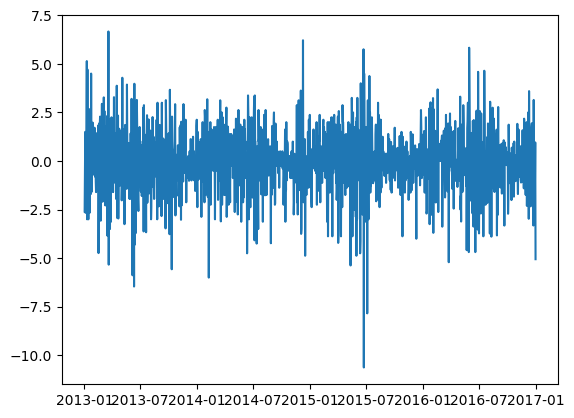

In [6]:
time_series = df["meantemp"].diff()
time_series.set_axis(df.date, inplace=True)
plt.plot(time_series)

Realice el preprocesamiento de la serie de tiempo __meantemp__ a manera de que sea una serie estacionaria con media 0 y varianza de 1. Una vez hecho, ajuste un modelo $AR(p)$ y $MA(q)$ para la misma serie de tiempo utilizando sus implementaciones. Pruebe cada uno de los métodos implementados.

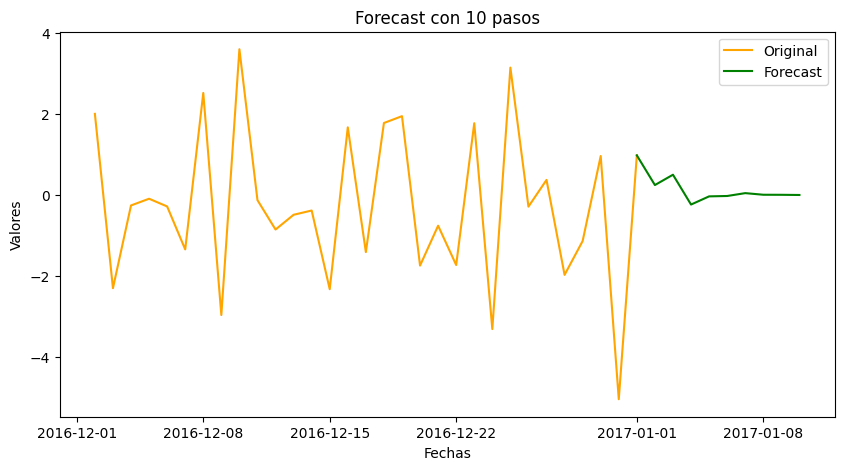

-----------------Polinomio-----------------
phi(z) = 1 + 0.12757455283613606z^1 + 0.10731845005633216z^2 + 0.18437192805743366z^3 
-----------------Raíces del polinomio-----------------
[-1.02447852-1.62725583j -1.02447852+1.62725583j  1.46688116+0.j        ]
Es causal


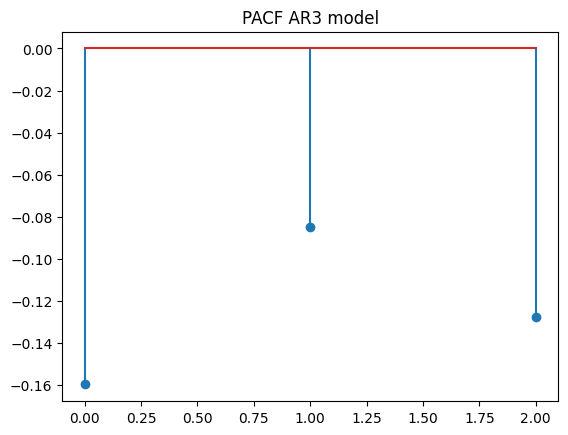

In [7]:
AR = AutoRegressive(p=3)
AR.fit(time_series[1:])
AR.forecast(steps = 10)
AR.print_poly()
AR.print_roots()
AR.is_causal()
AR.plot_pacf()

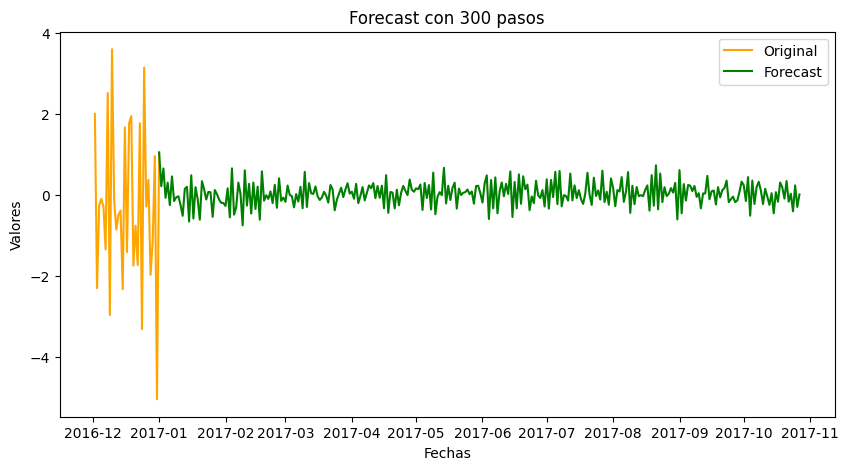

-----------------Polinomio-----------------
phi(z) = 1 - 0.00363737350122264z^1 + 0.004458957627503459z^2 - 0.021930001009792293z^3 + 0.027971449458376936z^4 - 0.06796226616486403z^5 + 0.007824837793512151z^6 - 0.13498855971937268z^7 - 0.2176699158843993z^8 - 0.13674796268260117z^9 + 0.0029142853130943386z^10 + 0.0010084874988811946z^11 - 0.0002268294540158529z^12 + 0.00012703638190786668z^13 - 0.0003596809479098225z^14 + 0.0003492761457314505z^15 - 0.0004296391422726831z^16 + 0.0003266069301930897z^17 - 0.00028694999491154415z^18 + 0.0003236808900337647z^19 - 0.0002466005496034338z^20 + 0.00024644736071989347z^21 - 0.00016401508178785434z^22 + 0.00027720295824959387z^23 - 0.0003287726989154778z^24 + 0.00014334261787877112z^25 - 0.00017105234139647024z^26 + 0.00020589288021286313z^27 - 0.0003131908137197716z^28 + 0.0002429525303599929z^29 - 4.5003676458695485e-05z^30 + 0.00021636880489224662z^31 - 0.00046581604059380184z^32 + 0.0003932892106801358z^33 - 7.966885355626875e-05z^34 - 3.86

In [8]:
MA = MovingAverages(q = 50, m = 300)
MA.fit(time_series[1:].values)
MA.forecast()
MA.print_poly()
MA.print_roots()
MA.is_invertible()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2804db8-c522-4d84-9303-c92a1545f152' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>